In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import discretize
from discretize import TensorMesh

try:
    from pymatsolver import Pardiso as Solver
except ImportError:
    from SimPEG import SolverLU as Solver
    
import SimPEG.electromagnetics.frequency_domain as fdem
from SimPEG.utils import mkvc, plot_1d_layer_model
from SimPEG import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)

plt.rcParams.update({"font.size": 16, "lines.linewidth": 2, "lines.markersize": 8})

In [5]:
# path to the directory containing our data
dir_path = "./3d_simulation_data/"
data_filename = dir_path + "em3dfm_1d_data_3dMagFluxDens.txt"

In [6]:
location_index = 0

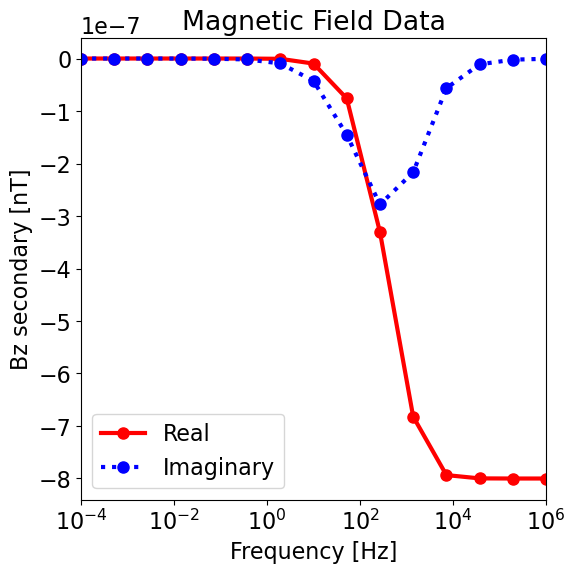

In [7]:
dobs = np.loadtxt(str(data_filename), skiprows=1)
ntx = int((dobs.shape[1]-1)/2)

# Define receiver locations and observed data
frequencies = dobs[:, 0]
dobs_real = dobs[:, 1::2].T
dobs_imag = dobs[:, 2::2].T

# Plot FEM response for all frequencies
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.semilogx(frequencies, (10**9)*dobs_real[location_index, :], "r-o", lw=3)
ax.semilogx(frequencies, (10**9)*dobs_imag[location_index, :], "b:o", lw=3)
ax.set_xlim((np.min(frequencies), np.max(frequencies)))
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Bz secondary [nT]")
ax.set_title("Magnetic Field Data")
ax.legend(["Real", "Imaginary"])
plt.show()

## Mapping

In [1]:
mesh = discretize.utils.load_mesh(file_name="./mesh/3d_mesh.json")
inversion_mesh_1d = discretize.utils.load_mesh(file_name="./mesh/inversion_mesh_1d.json")

NameError: name 'discretize' is not defined

In [16]:
mesh1D = discretize.TensorMesh([mesh.h[2]], x0=mesh.x0[[2]])
active_inds_1d = mesh1D.gridCC[:] < 0  # active indices are below the surface

resistivity_air = 1e8 #Assume known

mapping = (
    maps.SurjectVertical1D(mesh)
    *maps.InjectActiveCells(  # populates 3D space from a 2D model
        mesh1D, active_inds_1d, resistivity_air
    )
    *maps.ExpMap(nP=inversion_mesh_1d.nC)
    )

In [17]:
mesh1D = discretize.TensorMesh([mesh.h[2]], x0=mesh.x0[[2]])
active_inds_1d = mesh1D.gridCC[:] < 0  # active indices are below the surface
mapping_1d = (
    maps.SurjectVertical1D(mesh)
    *maps.InjectActiveCells(  # populates 3D space from a 2D model
        mesh1D, active_inds_1d, resistivity_air
    )
    *maps.ExpMap(nP=inversion_mesh_1d.nC)
    )

## Survey

In [8]:
x_positions = np.arange(0, 10000, 500)

In [22]:
frequencies = np.logspace(-2, 8, 15)
moment = 100

# Defining transmitter locations
xtx, ytx, ztx = np.meshgrid([x_positions[location_index]], [0], [30])
source_locations = np.c_[mkvc(xtx), mkvc(ytx), mkvc(ztx)]
ntx = np.size(xtx)

# Define receiver locations
xrx, yrx, zrx = np.meshgrid([x_positions[location_index]+ 10], [0], [30])
receiver_locations = np.c_[mkvc(xrx), mkvc(yrx), mkvc(zrx)]

source_list = []  # Create empty list to store sources

dpreds = []

# Each unique location and frequency defines a new transmitter
for ii in range(ntx):
    source_list = [] 
    # Define receivers of different type at each location
    bzr_receiver = fdem.receivers.PointMagneticFluxDensitySecondary(
        receiver_locations[ii, :], "z", "real"
    )

    bzi_receiver = fdem.receivers.PointMagneticFluxDensitySecondary(
        receiver_locations[ii, :], "z", "imag"
    )
    receivers_list = [bzr_receiver, bzi_receiver]
    for jj in range(len(frequencies)):
        # Must define the transmitter properties and associated receivers
        source_list.append(
            fdem.sources.MagDipole(
                receivers_list,
                frequencies[jj],
                source_locations[ii, :],
                orientation="z",
                momemt = moment
            )
        )

# create the survey and problem objects for running the forward simulation
survey = fdem.Survey(source_list)
prob = fdem.Simulation3DMagneticFluxDensity(
    mesh, survey=survey, rhoMap=mapping, solver=Solver
)

In [11]:
# Recover the vector data structure
bz_real = dobs_real[location_index]
bz_imag = dobs_imag[location_index]

dobs_recovered = np.empty(bz_real.size + bz_imag.size, dtype=bz_real.dtype)
dobs_recovered[0::2] = bz_real
dobs_recovered[1::2] = bz_imag

In [12]:
uncertainties = 0.01 * np.abs(dobs_recovered) * np.ones(np.shape(dobs_recovered))

In [19]:
data_object = data.Data(survey, dobs=dobs_recovered, noise_floor=uncertainties)

## Weighted Least-Squares Inversion

In [14]:
# estimated host conductivity (S/m)
estimated_resistivity = 100

# minimum skin depth
d_min = 500.0 * np.sqrt(estimated_resistivity/ frequencies.max())
print("MINIMUM SKIN DEPTH: {} m".format(d_min))

# maximum skin depth
d_max = 500.0 * np.sqrt(estimated_resistivity/ frequencies.min())
print("MAXIMUM SKIN DEPTH: {} m".format(d_max))

MINIMUM SKIN DEPTH: 0.5 m
MAXIMUM SKIN DEPTH: 50000.0 m


In [20]:
dmisfit = data_misfit.L2DataMisfit(simulation=prob, data=data_object)
reg = regularization.WeightedLeastSquares(inversion_mesh_1d)
opt = optimization.InexactGaussNewton(maxIterCG=10, remember="xc")
invProb = inverse_problem.BaseInvProblem(dmisfit, reg, opt)

betaest = directives.BetaEstimate_ByEig(beta0_ratio=0.05, n_pw_iter=1, seed=1)
target = directives.TargetMisfit()

directiveList = [betaest, target]
inv = inversion.BaseInversion(invProb, directiveList=directiveList)

In [21]:
m0 = np.log(estimated_resistivity) * np.ones(inversion_mesh_1d.nC)
mrec = inv.run(m0)

SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.

                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation3DMagneticFluxDensity problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.01e+08  1.55e+12  0.00e+00  1.55e+12    2.19e+12      0              
   1  1.01e+08  2.64e+11  2.51e+02  2.89e+11    2.71e+11      0              
   2  1.01e+08  6.17e+10  9.35e+02  1.56e+11    2.30e+10      0   Skip BFGS  
   3  1.01e+08  6.55e+10  8.52e+02  1.51e+11    5.51e+09    